In [ ]:
!pip install pyod

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import random
from sklearn.datasets import make_spd_matrix;
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from pyod.models.ocsvm import OCSVM
from pyod.utils.example import visualize
from pyod.models.pca import PCA
from pyod.models.gmm import GMM

In [3]:
class GenerateNumericalDataset:
  def __init__(self, n_Gauss_comp , samples , cont, n_features , num_cat = 0 , missing_percent= 0, cov_type = "tied-diag" , dependence_percent = 0):
    self.cont = cont
    self.samples = samples
    self.n_features = n_features
    self.n_Gauss_comp = n_Gauss_comp
    self.n_outliers = int(self.cont * self.samples)
    self.n_inliers = self.samples - self.n_outliers
    self.cov_type = cov_type
    self.num_cat = num_cat

  def mixing_coefficients(self):
    """
    This function is used to create the mixing coefficients 
    during data generation by 
    Gaussian mixture models
    """
    sum_x =0;
    x  = []
    for i in range(self.n_Gauss_comp):
      x_temp = (round(random.uniform(0,1), 2));
      x.append(x_temp)
      sum_x = sum_x + x_temp;
    mix_coef = [num / sum_x for num in x]
    return mix_coef

  def mu_vector( self , low_range, high_range):
    """
    This function is used to generate the mean vector for various
    Gaussians in GMM
    """
    mu_set = set()
    while(len(mu_set) < self.n_features):
      mu_set.add(random.randint(low_range, high_range))
    return list(mu_set);


  def make_cov_matrix(self):
    mincv = 0.1;
    cov_mat = [];
    if self.cov_type.lower() == "tied-full":
      print("tied-full")
      cov_m_temp = make_spd_matrix(self.n_features)
      cov_m = np.linalg.cholesky(cov_m_temp)
      print(cov_m)
      cov_mat.append(cov_m)
      return cov_mat
    elif self.cov_type.lower() == "tied-diag":
      print("tied-diag")
      cov_m = (mincv + mincv * np.dot(np.random.random((self.n_features, 1)),np.ones((1, self.n_features)))) ** 2;
      cov_m = np.diag(np.diag(cov_m)) 
      print(cov_m)
      cov_mat.append(cov_m)
      return cov_mat
    elif self.cov_type.lower() == "tied-sph":
      #cov_m = (mincv + mincv * np.dot(rand((n_components, 1)),np.ones((1, n_features)))) ** 2
      cov_m = np.random.random()* np.eye(self.n_features,self.n_features)
      print(cov_m)
      cov_mat.append(cov_m)
      return cov_mat
    elif self.cov_type.lower() == "diff-full":
      print("diff-full")
      for i in range(self.n_Gauss_comp):
        print("///////////////////")
        cov_m_temp = make_spd_matrix(self.n_features)
        cov_m = np.linalg.cholesky(cov_m_temp)
        print(cov_m)
        cov_mat.append(cov_m)
      return cov_mat
    elif self.cov_type.lower() == "diff-diag":
      print("diff-diag")
      for i in range(self.n_Gauss_comp):
        print("///////////////////")
        cov_m = (mincv + mincv * np.dot(np.random.random((self.n_features, 1)),np.ones((1, self.n_features)))) ** 2;
        cov_m = np.diag(np.diag(cov_m))
        print(cov_m)
        cov_mat.append(cov_m)
      return cov_mat

  def generate_cov_matrix(self):
    """
    This function is used to generate covariance matrix
    for various Gaussians in GMM
    """
    #spd_matrix = make_spd_matrix(self.n_features)
    #cov_matrix = np.linalg.cholesky(spd_matrix) 
    #print("cov_matrix : ", cov_matrix)
    return 1# cov_matrix

  def generate_multivariate_gaussian_data(self,mean, cov):
    """
    This function is used to generate single multivariate Gaussian RV
    """
    z = []
    for i in range(self.n_features):
      u1 = np.random.uniform(0,1)
      u2 = np.random.uniform(0,1)
      z1 = math.sqrt(-2*math.log(u1))*math.cos(2*math.pi*u2)
      z.append(z1)
    z = np.array(z)
    mvn_rv = mean + z.dot(cov)
    return mvn_rv

  def generate_GMM_inliers(self ):
    """
    This function is used to generate GMM inliers data 
    """
    mix_probab = self.mixing_coefficients()#(self.n_Gauss_comp);
    X_Train = []
    Y_Train = []
    mu_val = []
    #cov_mat = []
    cov_mat = self.make_cov_matrix()


    for val in mix_probab:
      num_samples = int(val * self.n_inliers);
      print("num_samples: ",num_samples)
      mu_val = self.mu_vector(1,40)#self.n_features, 1, 40); 
      print("mu_val: ",mu_val)
      cov_mat = self.generate_cov_matrix()#(self.n_Gauss_comp, self.n_features)
      for j in range(num_samples):
        X_train_temp  = self.generate_multivariate_gaussian_data(mu_val, cov_mat) #(self.n_features, mu_val, cov_mat)
        X_Train.append(X_train_temp)
      print(len(X_Train))
    return X_Train 

  def generate_Uniform_outliers(self):
    """
    This function is used to generate uniform outliers data 
    """
    outliers = np.random.uniform(-20, 20 , size= (self.n_outliers, self.n_features));
    return outliers;

  def multinouli(self , n_cat ):
    sum_x =0;
    x  = []
    pdf_list =[]
    for i in range(n_cat):
      x_temp = (round(random.uniform(0,1), 2));
      x.append(x_temp)
      sum_x = sum_x + x_temp;
    p_list = [num / sum_x for num in x]
    cdf_list = []
    sum = 0
    for i in range(len(p_list)):
      sum = sum + p_list[i]
      cdf_list.append(sum)
    r_num = np.random.uniform(0,1)
    for i in range(len(cdf_list)):
      if r_num < cdf_list[i]:
        return i 


  def generate_categorical(self ):
    n_cat_var = self.num_cat;
    cat_col = []
    for i in range(n_cat_var):
      cat_col_temp = []
      num_categories = self.multinouli(10)
      num_categories = num_categories +2
      #print("num_categories: ",num_categories)
      #cat_col= []
      #for j in range(n_cat_var):
      cat_val = self.multinouli(num_categories)
      chr_val =  chr(65+cat_val) #+ chr(65+cat_val) 
      #print(chr_val)
      #cat_col_temp.append(chr_val)
      cat_col.append(chr_val)
    return cat_col
    #print(cat_col)

  def combine_inlier_outlier_label(self):
    column_list = []
    for i in range(self.n_features):
      col_name = 'X'+str(i)
      column_list.append(col_name)
    inliers = self.generate_GMM_inliers() #self.n_Gauss_comp , self.n_features, self.n_inliers)
    df_inliers = pd.DataFrame(inliers, columns =column_list)
    df_inliers['Label']= 0
    # append label 1
    # outliers , label 0
    outliers = self.generate_Uniform_outliers()#self.n_outliers, self.n_features)
    df_outliers = pd.DataFrame(outliers , columns=column_list)
    df_outliers['Label']= 1
    # append label 1
    # create a pd dataframe

    final_dataset = pd.concat([df_outliers, df_inliers], axis=0, ignore_index=True)


    if(self.num_cat>0):
      cat_column_list = []
      for i in range(self.num_cat):
        cat_col_name = 'C'+str(i)
        cat_column_list.append(cat_col_name)
      #print(cat_column_list)
      num_datapoints = len(df_outliers)+len(df_inliers)
      cat_data = []
      for i in range(num_datapoints):
        col_temp = self.generate_categorical()
        #print("col_temp: ",col_temp)
        cat_data.append(col_temp)
      #print(cat_data)
      df_cat = pd.DataFrame(cat_data, columns = cat_column_list)
      final_dataset = pd.concat([df_cat, final_dataset], axis=1)

    #print(len(df_dataset))

    def calulate_likelihood():
      return 1;

    def calculate_posterior():
      return 2;
    #return df_dataset
    return final_dataset

In [19]:
obj1 = GenerateNumericalDataset(n_Gauss_comp = 4, samples=1000 , cont=0.30, n_features = 5 , num_cat =3 , missing_percent= 0, cov_type = "tied-full" , dependence_percent = 0)

In [20]:
data = obj1.combine_inlier_outlier_label()

tied-full
[[ 0.96301726  0.          0.          0.          0.        ]
 [-0.53745485  1.2826796   0.          0.          0.        ]
 [-0.85976984  1.10064464  1.23450532  0.          0.        ]
 [-0.21159088  0.74989056  0.15219592  0.43967611  0.        ]
 [ 0.17815716 -0.25390599  0.00738429  0.07380803  0.79088035]]
num_samples:  283
mu_val:  [32, 1, 34, 8, 9]
283
num_samples:  313
mu_val:  [4, 15, 18, 23, 25]
596
num_samples:  87
mu_val:  [37, 39, 15, 19, 30]
683
num_samples:  15
mu_val:  [33, 38, 6, 25, 29]
698


In [21]:
data

,C0,C1,C2,X0,X1,X2,X3,X4,Label
0,B,A,B,-6.894779,18.750713,-13.416626,0.791609,-1.192717,1
1,D,B,H,-19.376926,-14.723198,0.876197,5.242090,1.614078,1
2,F,F,A,-7.326806,-19.550013,19.751973,-10.258702,-17.448172,1
3,B,D,D,-3.730145,17.848700,10.590635,-10.074117,14.159935,1
4,A,E,E,-3.293916,2.793425,11.039958,13.392893,0.749905,1
...,...,...,...,...,...,...,...,...,...
993,I,C,F,32.470967,38.485619,7.241241,24.321373,29.071953,0
994,B,B,A,31.394444,35.862663,6.041115,24.779836,29.127796,0
995,A,A,E,32.546973,40.022918,6.060628,25.160512,29.583573,0
996,B,B,C,32.171814,38.878853,7.691816,24.149223,27.628465,0


# testing number of Gaussian components

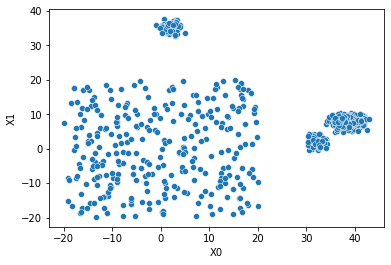

In [12]:
import seaborn as sns
sns.scatterplot(data=data, x=data["X0"], y= data["X1"])

# Testing number of dimensions

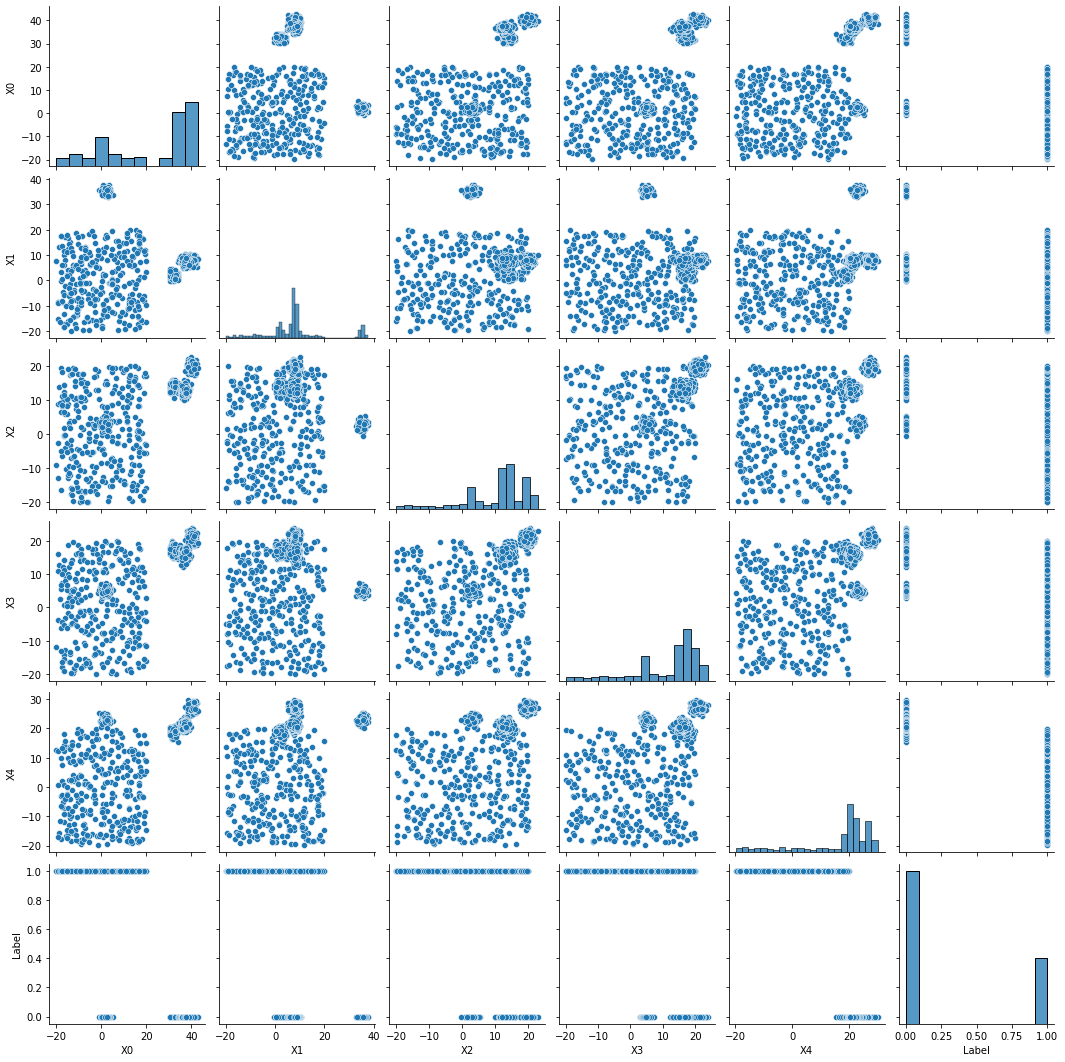

In [13]:
sns.pairplot(data)

# Generate missing values

In [14]:
import collections

In [15]:
df = pd.DataFrame({'A':[1,2,3],
                   'B':[4,5,6],
                   'C':[7,8,9]})

In [16]:
def missing_val(percent , df):
  replaced = collections.defaultdict(set)
  ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
  random.shuffle(ix)
  to_replace = int(round(percent*len(ix)))
  for row, col in ix:
    if len(replaced[row]) < df.shape[1] - 1:
        df.iloc[row, col] = np.nan
        to_replace -= 1
        replaced[row].add(col)
        if to_replace == 0:
            break
  return df

In [17]:
df_out = missing_val(0.3, df)

In [18]:
df_out

,A,B,C
0,1.0,4,7.0
1,2.0,5,NaN
2,NaN,6,NaN


# Apply anomaly detection

In [ ]:
! pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 147 kB 9.8 MB/s 
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=4a5f45da4a9a8203a62c0992444673f18b98b4ea5c20b1e9a17daf555c35e1a4
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
X_train

,X0,X1
25,15.315910,13.782194
791,6.935283,7.834171
198,-14.617806,-15.655339
452,3.192135,36.127836
826,6.432966,6.690851
...,...,...
185,-12.213255,-8.719893
392,26.398536,39.013064
266,-12.259741,2.977912
238,-9.262845,-3.550526


In [ ]:
def apply_anomaly_detection(data):
  X = data.loc[:, data.columns != "Label"]
  y= data["Label"]
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

  #initialize detector
  clf = OCSVM(nu=0.3, gamma=0.5,kernel = 'rbf') 
  clf.fit(X_train)
  # binary labels
  y_train_pred = clf.predict(X_train)
  y_test_pred = clf.predict(X_test) 

  # prediction visualization
  visualize(clf,X_train,
    y_train,
    X_test,
    y_test,
    y_train_pred,
    y_test_pred,
    show_figure=True,
    save_figure=False,)

In [ ]:
def calculate_metrics(predicted, actual):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predicted)):
        if   (predicted[i] == 0) & (actual[i] == 0):
            TP += 1
        elif (predicted[i] == 0) & (actual[i] == 1):
            FP += 1
        elif (predicted[i] == 1) & (actual[i] == 1):
            TN += 1
        else:
            FN += 1

    accuracy  = (TP + TN) / (TP + FP + TN + FN) 
    precision = (TP) / (TP + FP) 
    recall    = (TP) / (TP + FN) 
    f1_score  = (2 * precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1_score

In [ ]:
def evaluate(X_train,X_test,y_train,y_test,y_train_pred, y_test_pred):
  train_accuracy , train_precision, train_recall, train_f1_score = calculate_metrics(y_train_pred,y_train )
  test_accuracy , test_precision, test_recall, test_f1_score = calculate_metrics(y_test_pred, y_test )



In [ ]:
y_test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
y_test

714    0
767    0
406    0
408    0
260    1
      ..
335    0
72     1
593    0
55     1
541    0
Name: Label, Length: 200, dtype: int64

In [ ]:
y_train_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


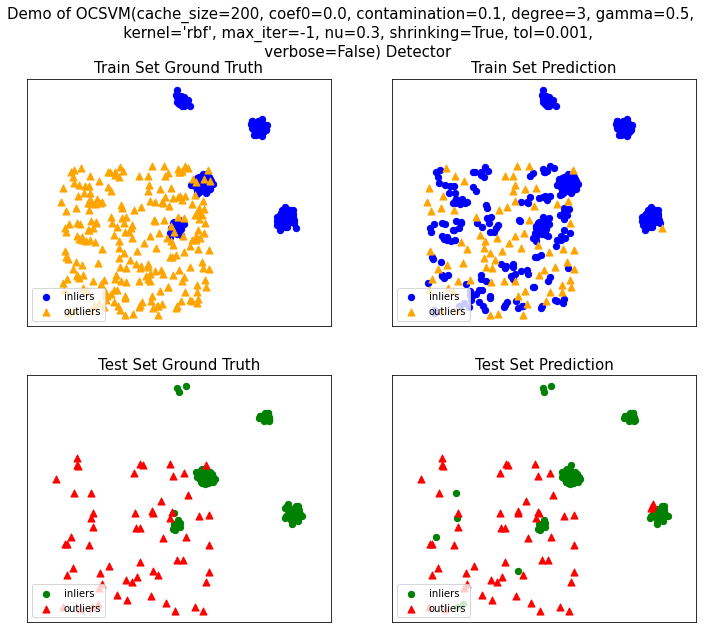

In [ ]:
apply_anomaly_detection()

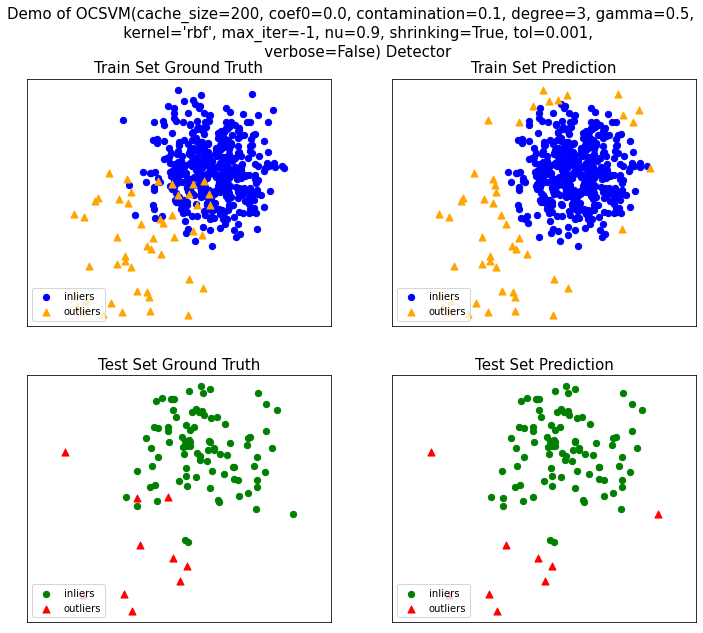

In [ ]:
#import libraries 
from pyod.utils.data import generate_data
from pyod.models.ocsvm import OCSVM
from pyod.utils.example import visualize
#generate dataset
X_train,X_test, y_train,y_test = generate_data(n_train=500, n_test=100, n_features=2,behaviour = 'new')
#initialize detector
clf = OCSVM(nu=0.9, gamma=0.5,kernel = 'rbf') 
clf.fit(X_train)
# binary labels
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test) 
# prediction visualization
visualize(clf,X_train,
    y_train,
    X_test,
    y_test,
    y_train_pred,
    y_test_pred,
    show_figure=True,
    save_figure=False,)

In [ ]:
type(X_train)

numpy.ndarray